In [1]:
import random
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# 设置硬币正面朝上的真实值
coin_num：硬币数

coins：硬币正面朝上的真实值

In [2]:
# 设置真实值
coin_num = 5
coins = []
for _ in range(coin_num):
    coins.append(random.randint(0, 100)/100)
coins

[0.84, 0.99, 0.63, 0.44, 0.54]

# 模拟投币

1. 随机抽取一个硬币
2. 投掷 n 次
3. 循环 m 次

1 为正面，0 为反面

In [3]:
n = 100
m = 1000
coin_result = np.zeros((m, n), dtype=int)

c_selected_record = []
for i_m in range(m):
    # 选择硬币
    coin_p = random.choice(coins)
    c_selected_record.append(coin_p)
    for i_n in range(n):
        # 开始投掷
        coin_result[i_m, i_n] = 1 if random.random() < coin_p else 0

coin_result.shape, Counter(c_selected_record)

((1000, 100), Counter({0.84: 193, 0.63: 198, 0.99: 220, 0.44: 200, 0.54: 189}))

# EM算法

初始化：随机初始化硬币正面的概率

1. E步：计算当前硬币的期望
2. M步：更新硬币参数

In [4]:
ini_coin_theta = np.array([random.randint(1, 99)/100 for _ in range(coin_num)])
# coin_theta = np.array([0.2, 0.9])
print('ini coin:', ini_coin_theta)

def E(coin_theta, coin_result):
    
    h_e_sum = np.zeros_like(coin_theta)
    t_e_sum = np.zeros_like(coin_theta)
    
    h_num = coin_result.sum(1)[:, None]
    t_num = coin_result.shape[1] - h_num
    
    # 可以评估每个硬币的得分
    coin_selected_p = h_num @ np.log(coin_theta[None]) + t_num @ np.log(1 - coin_theta[None])
    coin_selected_p = np.exp(coin_selected_p)
    coin_selected_p = coin_selected_p / coin_selected_p.sum(1)[:, None]
    
    h_e = coin_selected_p  * h_num
    t_e = coin_selected_p  * t_num
    
    return h_e.sum(0), t_e.sum(0), coin_selected_p

def M(h_e_sum, t_e_sum):
    return h_e_sum / (h_e_sum + t_e_sum)

max_step=1000
coin_result = np.array(coin_result)

h_e_record = []
t_e_record = []
theta_record = []
delta_record = []

coin_theta = ini_coin_theta
for i in tqdm(range(max_step)):
    h_e_sum, t_e_sum, coin_selected_p = E(coin_theta, coin_result)
    
    h_e_record.append(h_e_sum)
    t_e_record.append(t_e_sum)
    
    new_coin_theta = M(h_e_sum, t_e_sum)
    
    theta_record.append(new_coin_theta)
    
    delta =  ((new_coin_theta - coin_theta)**2).sum()
    
    delta_record.append(delta)
    
    # print(new_coin_theta)
    if delta < 1e-10:
        break
    coin_theta = new_coin_theta
    

h_e_record = np.array(h_e_record)
t_e_record = np.array(t_e_record)
theta_record = np.array(theta_record)
delta_record = np.array(delta_record)
    
i, coin_theta, coins

ini coin: [0.4  0.13 0.58 0.61 0.23]


  4%|██                                                        | 36/1000 [00:00<00:00, 4507.45it/s]


(36,
 array([0.62988197, 0.43099465, 0.84265886, 0.99086422, 0.53815304]),
 [0.84, 0.99, 0.63, 0.44, 0.54])

# 展示变化过程

In [6]:
def plot_list(f, x, y, labels, title):
    f.set_title(title)
    for i in range(y.shape[1]):
        f.plot(x, y[:, i], label = labels[i], linestyle='--')

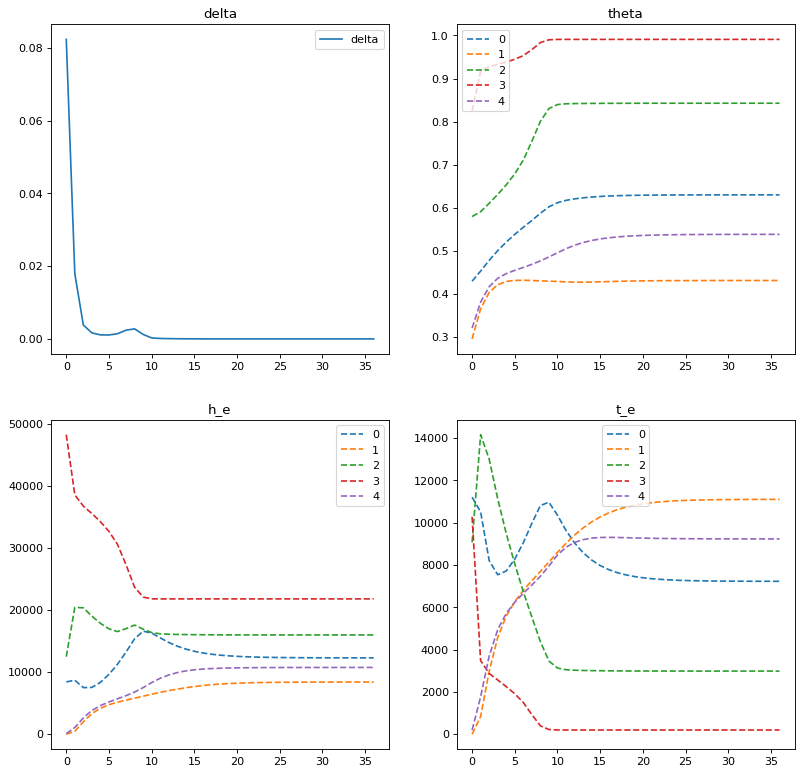

In [7]:
index = range(0, i+1)
labels = list(range(coin_theta.shape[0]))
figure, axes = plt.subplots(2, 2, figsize=(12,12), dpi=80)


axes[0, 0].set_title("delta")
axes[0, 0].plot(index, delta_record, label="delta")
plot_list(axes[0, 1], index, theta_record, labels=labels, title="theta")
plot_list(axes[1, 0], index, h_e_record, labels=labels, title="h_e")
plot_list(axes[1, 1], index, t_e_record, labels=labels, title="t_e")

for axe in axes:
    for a in axe:
        a.legend()